# Testing the RAG implementation

Purpose of the notebook: test which retrieval queries and generation prompts work best, which embedding models / LLM models, PDF text extraction approaches perform best
Evaluate on a manually coded validation set based on three sample reports

Evaluate
1.  RAG retrieval
2.  RAG generation

## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from thefuzz import process, fuzz
import re
import urllib3
import pymupdf
import requests
import os
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings


import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# import OpenAI API key from environment variable
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Select sample reports
Source: Sustainability Reporting Navigator (crowd-source list of CSRD-compliant reports for fiscal years starting on 01/01/2024)

Download CSV with information on all reports on the 08/04/2025 https://www.sustainabilityreportingnavigator.com/#/csrdreports 

In [2]:
# Open the csv data file
reports_24 = pd.read_csv('esg_reports_2024.csv')
print(len(reports_24))

277


In [3]:
# randomly select 3 reports from 2024
sample = reports_24.sample(n=3, random_state=3)
sample.head()

,Unnamed: 0,company_withAccessInfo,link,country,sector,industry,publication date,pages PDF,auditor
220,19,Continental AG,https://annualreport.continental.com/2024/en/s...,Germany,Transportation,Auto Parts,2025-03-18,125,PwC
58,266,Schneider Electric*,https://www.se.com/ww/en/assets/564/document/5...,France,Resource Transformation,Electrical & Electronic Equipment,2025-03-26,186,PwC & Mazars
89,103,Philips,https://www.results.philips.com/publications/a...,Netherlands,Infrastructure,Electric Utilities & Power Generators,2025-02-21,85,EY


## Manually hand code ground truth = validation set

In [6]:
validation_set = pd.read_excel('validation_dataset.xlsx')
print(validation_set.head())

              report_name query  \
0      ContinentalAG_2024  S1_E   
1  SchneiderElectric_2024  S1_E   
2      ContinentalAG_2024  S1_D   
3      ContinentalAG_2024  S1_A   
4  SchneiderElectric_2024  S1_F   

                                                text page_number  
0  In accordance with Section 76 (4) AktG, the Ex...          27  
1  Our 2025 sustainability commitments\nWith less...          33  
2  The globally applicable Code of\nConduct provi...          41  
3  The globally applicable Code of\nConduct provi...          41  
4  Our Speak Up Mindset\nSchneider Electric emplo...          41  


In [7]:
# print how many text chunks per query, per report name
print(validation_set.groupby(['query', 'report_name' ]).size())

query  report_name           
S1_A   ContinentalAG_2024        22
       SchneiderElectric_2024    24
S1_B   ContinentalAG_2024        14
       SchneiderElectric_2024     4
S1_C   ContinentalAG_2024        19
       SchneiderElectric_2024    18
S1_D   ContinentalAG_2024        23
       SchneiderElectric_2024    10
S1_E   ContinentalAG_2024        12
       SchneiderElectric_2024    24
S1_F   ContinentalAG_2024        15
       SchneiderElectric_2024    23
S1_G   ContinentalAG_2024         5
       SchneiderElectric_2024     8
dtype: int64


Text(0.5, 1.0, 'Distribution of Text Chunk Lengths (Characters)')

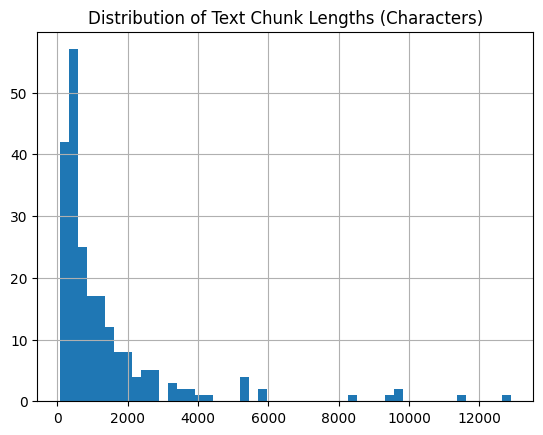

In [8]:
# graph the number of characters per text chunk
validation_set['text_length'] = validation_set['text'].apply(lambda x: len(x))
validation_set['text_length'].hist(bins=50)
plt.title('Distribution of Text Chunk Lengths (Characters)')

C:\Users\julia\AppData\Local\Temp\ipykernel_18024\3170922132.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Report Name')


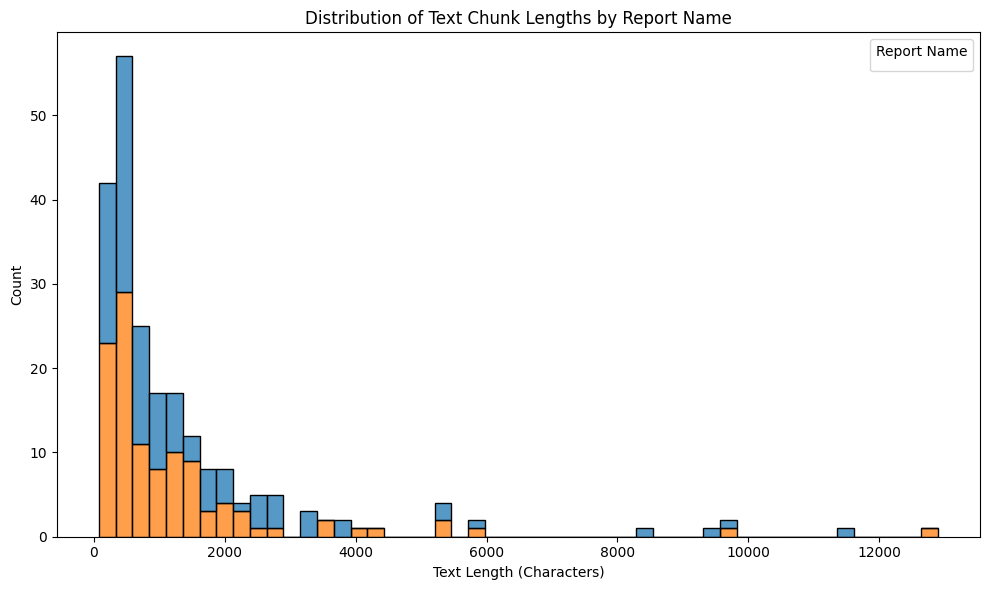

In [9]:
# Compute text lengths
validation_set['text_length'] = validation_set['text'].apply(len)

# Set up the figure
plt.figure(figsize=(10, 6))

# Use seaborn to plot the histogram by report_name
sns.histplot(data=validation_set, x='text_length', hue='report_name', bins=50, kde=False, multiple='stack')

# Customize the plot
plt.title('Distribution of Text Chunk Lengths by Report Name')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
plt.legend(title='Report Name')
plt.tight_layout()
plt.show()

## Evaluate the performance of different approaches


1. Approach: Compare on sentence level whether ground truth sentences are as a whole retrieved

In [10]:
ground_truth_sentences = set(['Equal pay /nFair and equitable pay is a core component of the Group’s compensation philosophy.',
                            'It is in line with the principle of equal pay for equal work.',
                            '100 % of Schneider are paid /nat least a living wage, which /nwas recognized for the /nsecond consecutive year by /nthe Living Wage Employer /nCertification from Fair /nWage Network.'])
retrieved_sentences = set(['Fair and equitable pay is a core component of the Group’s compensation philosophy.',
                           'It is in line with the principle of equal pay for equal work.',
                           '100 % of Schneider are paid /nat least a living wage, which /nwas recognized for the /nsecond consecutive year'])

found_ground_truth_sentences = set()
for sentence in retrieved_sentences:
    if sentence in ground_truth_sentences:
        found_ground_truth_sentences.add(sentence)

print(found_ground_truth_sentences)

{'It is in line with the principle of equal pay for equal work.'}


This approach is very restrictive and cause for lower scores whenever the cunk size abbreviates sentences, eventhough the LLM could still understand the meaning.

2. Approach fuzzy string matching


In [11]:
found_matches = 0
for sentence in retrieved_sentences:
    best_match, score = process.extractOne(sentence, ground_truth_sentences, scorer=fuzz.ratio)
    if score > 80:
        found_matches += 1
        print(f"Score: {score}, Retrieved sentence: '{sentence}', Found match: '{best_match}'")

Score: 93, Retrieved sentence: 'Fair and equitable pay is a core component of the Group’s compensation philosophy.', Found match: 'Equal pay /nFair and equitable pay is a core component of the Group’s compensation philosophy.'
Score: 100, Retrieved sentence: 'It is in line with the principle of equal pay for equal work.', Found match: 'It is in line with the principle of equal pay for equal work.'


In [12]:
def evaluate_retrieval_sentence_level(retrieved_docs, ground_truth_texts):
    """
    Evaluates retrieval performance on a sentence level using fuzzy string matching.

    Args:
        retrieved_docs (list): A list of Document objects retrieved by LangChain.
        ground_truth_texts (list): A list of ground-truth text snippets from the validation set.
        score_threshold (int): The similarity score (0-100) required to consider a sentence a match.

    Returns:
        dict: A dictionary containing precision, recall, and f1-score.
    """
    # 1. Extract all ground-truth and retrieved sentences
    all_ground_truth_sentences = set()
    for text in ground_truth_texts:
        sentences = sent_tokenize(text)
        all_ground_truth_sentences.update([s.strip() for s in sentences if s.strip()])

    if not all_ground_truth_sentences:
        return {"precision": None, "recall": None, "f1": None}

    all_retrieved_sentences = set()
    for doc in retrieved_docs:
        chunk_sentences = sent_tokenize(doc.page_content)
        all_retrieved_sentences.update([s.strip() for s in chunk_sentences if s.strip()])

    if not all_retrieved_sentences:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    # 2. For each retrieved sentence, find its best match in the ground truth sentences.
    found_matches = 0
    for retrieved_sentence in all_retrieved_sentences:
        # process.extractOne finds the best matching string from a collection.
        # It returns a tuple: (best_match_string, score)
        best_match, score = process.extractOne(
            retrieved_sentence, 
            all_ground_truth_sentences, 
            scorer=fuzz.ratio
        )
        
        # If the best match has a score above our threshold, we count it as a successful find.
        if score >= 80:
            found_matches += 1

    # 3. Calculate metrics based on the fuzzy matches.
    true_positives = found_matches
    
    # Precision = (Relevant sentences found) / (Total sentences retrieved)
    precision = true_positives / len(all_retrieved_sentences) if all_retrieved_sentences else 0.0
    
    # Recall = (Relevant sentences found) / (Total relevant sentences that exist)
    recall = true_positives / len(all_ground_truth_sentences) if all_ground_truth_sentences else 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"precision": precision, "recall": recall, "f1": f1}

In [13]:
def evaluate_retrieval(retrieval_results):
    """
    Evaluates the retrieval performance of a LangChain vector store against a validation set.

    Args:
        retrieval_results (list): A list of Document objects retrieved by LangChain.

    Returns:
        dict: A dictionary containing precision, recall, and f1-score.
    """
    evaluation_results_all = []
    
    for report_name, queries_results in retrieval_results.items():
        for query_key, retrieved_documents in queries_results.items():

            # Get the corresponding ground-truth texts from the validation set
            gt_texts = validation_set[
                (validation_set['report_name'] == report_name) & 
                (validation_set['query'] == query_key)
            ]['text'].tolist()

            if not gt_texts:
                continue

            # Evaluate the retrieval performance
            scores = evaluate_retrieval_sentence_level(
                retrieved_docs=retrieved_documents,
                ground_truth_texts=gt_texts
            )

            evaluation_results_all.append({
                "report_name": report_name,
                "query": query_key,
                **scores
            })

    evaluation_results_mean = pd.DataFrame(evaluation_results_all).groupby(['query'])[['precision', 'recall', 'f1']].mean().reset_index()
    overall_mean = evaluation_results_mean[['precision', 'recall', 'f1']].mean()
    evaluation_results_mean.loc['Overall Mean'] = overall_mean

    print("--- Retrieval Performance Summary ---")
    print(evaluation_results_mean.round(3))

### 0: Baseline approach based on Ni et al. (2023)
based on: Ni, J., Bingler, J., Colesanti-Senni, C., Kraus, M., Gostlow, G., Schimanski, T., Stammbach, D., Vaghefi, S. A., Wang, Q., Webersinke, N., Wekhof, T., Yu, T., & Leippold, M. (2023). CHATREPORT: Democratizing Sustainability Disclosure Analysis through LLM-based Tools. Swiss Finance Institute Research Paper, No. 23-111. https://doi.org/10.48550/arXiv.2307.15770

- PDF text extraction: MyPuPDF
- Retrieval:
    - Embedding model: OpenAI text-embedding-ada-002
    - top k: 20
    - chunk size: 500
    - chunk overlap: 20

In [14]:
# Code based on Ni et al. (2023)
TOP_K = 20
CHUNK_SIZE = 500
CHUNK_OVERLAP = 20

# 1. Load the PDF
def load_pdf(path=None, url=None):
    assert (path is not None) != (url is not None), "Either path or url must be provided"
    
    if path:
        return pymupdf.open(path)
    else:
        response = requests.get(url)
        pdf_bytes = io.BytesIO(response.content)
        return pymupdf.open(stream=pdf_bytes, filetype='pdf')
    
# 2. Extract text from the PDF
def extract_text(pdf):
    text_list = [page.get_text() for page in pdf]
    all_text = ''.join(text_list)
    return text_list, all_text

# 4. Create or Load Vector Store
def get_retriever(pdf, db_path, top_k=TOP_K):
    embeddings = OpenAIEmbeddings()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    if os.path.exists(db_path):
        doc_search = FAISS.load_local(db_path, embeddings=embeddings, allow_dangerous_deserialization=True)
    else:
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

# 5. Retrieve relevant chunks
def retrieve_chunks(retriever, queries):
    section_text_dict = {}

    for key, prompts in queries.items():
        if key == 'general' and isinstance(prompts, list):
            combined_docs = []
            for prompt in prompts:
                combined_docs.extend(retriever.invoke(prompt)[:5])
            section_text_dict[key] = combined_docs
        else:
            section_text_dict[key] = retriever.invoke(prompts)
    
    return section_text_dict

# for preparing filenames
def prepare_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "", name)

In [15]:
# Defined retrieval queries based on the ESRS S1 requirements

QUERIES = {
    #'general': ["What is the company of the report?", "What sector does the company belong to?", "Where is the company located?"],
    'S1_A': "How does the company manage and disclose material impacts, risks and opportunities related to the own workforce?",
    'S1_B': "What are the material risks and opportunities arising from the company’s impacts and dependencies on people in its own workforce?",
    'S1_C': "What are the company’s human rights practices, risks and incidents related to the own workforce?",
    'S1_D': "What are the company’s processes and policies for engaging with own workers and workers’ representatives about impacts?",
    'S1_E': "What are the company’s policies on non-discrimination, diversity and inclusion in the own workforce?",
    'S1_F': "What are the company’s processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns?",
    'S1_G': "How is the company’s workfoce social protection coverage?",
}

In [16]:
# Now apply the functions to the 3 sampled reports
all_results = {}

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_OpenAI/{filename}"
        retriever, doc_search = get_retriever(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")



Processing: ContinentalAG_2024

Processing: SchneiderElectric_2024

Processing: Philips_2024


Note: **Ressorces needed for 3 reports**
- Time: 1.5 min (--> 13 h for 500 reports)
- Costs: 0.2 Dollar (--> 100$ for 500 reports)

In [47]:
# save results
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.to_csv('retrieval_results_0_OpenAI.csv', index=True)

In [2]:
# read in the results
retrieval_results = pd.read_csv('retrieval_results_0_OpenAI.csv', index_col=0)

In [17]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.363   0.061  0.103
1             S1_B      0.156   0.191  0.164
2             S1_C      0.204   0.154  0.175
3             S1_D      0.237   0.118  0.157
4             S1_E      0.356   0.183  0.237
5             S1_F      0.123   0.058  0.079
6             S1_G      0.107   0.230  0.139
Overall Mean   NaN      0.221   0.142  0.151


In [ ]:
# with old validation set
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.156   0.191  0.164
1             S1_B      0.490   0.067  0.118
2             S1_C      0.472   0.148  0.225
3             S1_D      0.279   0.200  0.233
4             S1_E      0.345   0.297  0.319
5             S1_F      0.296   0.240  0.252
6             S1_G      0.404   0.208  0.271
7             S1_H      0.262   0.147  0.189
8             S1_I      0.037   0.207  0.049
9             S1_J      0.396   0.274  0.323
10            S1_K      0.520   0.334  0.382
11            S1_L      0.063   0.127  0.080
Overall Mean   NaN      0.310   0.203  0.217


### A) Evaluate open source embedding models
#### 1. Qwen3-Embedding-0.6B
- Place 4 in MTEB Leaderboard (26.06.2025), best for 2 GB Memory Usage https://huggingface.co/spaces/mteb/leaderboard
- Number of Paramaters: 0.6B
- Context Length: 32k
- Embedding Dimension: Up to 1024, supports user-defined output dimensions ranging from 32 to 1024
https://huggingface.co/Qwen/Qwen3-Embedding-0.6B 

In [ ]:
# A1. Create or Load Vector Store for Qwen
def get_retriever_qwen(pdf, db_path, top_k=TOP_K):

    # 1. Initialize embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={'device': 'cpu'} # specify device='cuda' if GPU and PyTorch available
    )

    # 2. Split the document into chunks (same logic as before).
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", " "],
    )

    chunks = []
    page_idx = []

    for i, page in enumerate(pdf):
        page_chunks = text_splitter.split_text(page.get_text())
        page_idx.extend([i + 1] * len(page_chunks))
        chunks.extend(page_chunks)

    # 3. Create or load the FAISS vector store
    if os.path.exists(db_path):
        print(f"Loading existing FAISS DB from {db_path}")
        doc_search = FAISS.load_local(
            db_path, 
            embeddings=embeddings, 
            allow_dangerous_deserialization=True # Be sure you trust the source of the DB file
        )
    else:
        print(f"Creating new FAISS DB at {db_path}")
        doc_search = FAISS.from_texts(
            chunks,
            embeddings,
            metadatas=[{"source": str(i), "page": str(idx)} for i, idx in enumerate(page_idx)]
        )
        doc_search.save_local(db_path)

    # 4. Create the retriever (same logic as before).
    retriever = doc_search.as_retriever(search_kwargs={"k": top_k})
    return retriever, doc_search

In [21]:
# Now apply on the sample reports
all_results = {}
#start_time = time.time()

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        PATH = f"./sample_reports/{filename}.pdf"
        pdf = load_pdf(path=PATH) 
        text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_Qwen/{filename}"
        retriever, doc_search = get_retriever_qwen(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
        print(f"Successfully processed and retrieved chunks for {filename}")
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")

#print(f"Computation time: {(time.time() - start_time) / 60:.2f} minutes")


Processing: ContinentalAG_2024
Loading existing FAISS DB from ./faiss_db_Qwen/ContinentalAG_2024
Successfully processed and retrieved chunks for ContinentalAG_2024

Processing: SchneiderElectric_2024
Loading existing FAISS DB from ./faiss_db_Qwen/SchneiderElectric_2024
Successfully processed and retrieved chunks for SchneiderElectric_2024

Processing: Philips_2024
Loading existing FAISS DB from ./faiss_db_Qwen/Philips_2024
Successfully processed and retrieved chunks for Philips_2024


**Ressorces needed** for 3 reports
- Time: 
    - on local CPU: 3h (--> 20 days for 500 reports)
- Costs: 0 Dollar (--> opensource)

In [22]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.281   0.092  0.137
1             S1_B      0.133   0.412  0.194
2             S1_C      0.126   0.249  0.167
3             S1_D      0.178   0.192  0.184
4             S1_E      0.257   0.288  0.266
5             S1_F      0.177   0.206  0.190
6             S1_G      0.034   0.105  0.051
Overall Mean   NaN      0.169   0.221  0.170


In [ ]:
# with old validation set
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.149   0.168  0.154
1             S1_B      0.468   0.061  0.109
2             S1_C      0.388   0.112  0.174
3             S1_D      0.271   0.217  0.241
4             S1_E      0.273   0.234  0.252
5             S1_F      0.269   0.178  0.204
6             S1_G      0.411   0.215  0.278
7             S1_H      0.305   0.160  0.210
8             S1_I      0.019   0.180  0.029
9             S1_J      0.396   0.271  0.321
10            S1_K      0.521   0.325  0.384
11            S1_L      0.059   0.093  0.072
Overall Mean   NaN      0.294   0.185  0.202


### C) Retrieval settings
- chunksize (1000)
- chunk overlap (200)
- top K
- reranker
- chunking
    - semantic chunking

In [ ]:
# pip install langchain_experimental
from langchain_experimental.text_splitter import SemanticChunker

# In your get_retriever function...
# Note: You pass the embeddings object directly to the splitter.
text_splitter = SemanticChunker(embeddings)

### B) Test retrieval queries

In [23]:
### Queries not as questions but bullet point
QUERIES = {
    'S1_A': "management and disclosure of material impacts, risks and opportunities related to the own workforce",
    'S1_B': "material risks and opportunities arising from impacts and dependencies on own workforce",
    'S1_C': "human rights practices, risks and incidents related to the own workforce",
    'S1_D': "processes and policies for engaging with own workers and workers’ representatives about impacts",
    'S1_E': "policies on non-discrimination, diversity and inclusion in the own workforce",
    'S1_F': "processes, policies and approaches to remediate negative impacts and channels for own workers to raise concerns",
    'S1_G': "social protection coverage in the own workforce",
}

all_results = {}

for idx, row in sample.iterrows():
    filename = f"{prepare_filename(row['company_withAccessInfo'])}_2024"
    filename = filename.replace(" ", "")
    print(f"\nProcessing: {filename}")

    try:
        #PATH = f"./sample_reports/{filename}.pdf"
        #pdf = load_pdf(path=PATH) 
        #text_list, all_text = extract_text(pdf)
        DB_PATH = f"./faiss_db_OpenAI/{filename}"
        retriever, doc_search = get_retriever(pdf, db_path=DB_PATH)
        results = retrieve_chunks(retriever, queries=QUERIES)
        all_results[filename] = results
    
    except Exception as e:
        print(f"Error processing {row['company_withAccessInfo']}: {e}")


Processing: ContinentalAG_2024

Processing: SchneiderElectric_2024

Processing: Philips_2024


In [24]:
evaluate_retrieval(all_results)

--- Retrieval Performance Summary ---
             query  precision  recall     f1
0             S1_A      0.416   0.071  0.119
1             S1_B      0.183   0.216  0.190
2             S1_C      0.147   0.114  0.128
3             S1_D      0.200   0.089  0.123
4             S1_E      0.454   0.251  0.317
5             S1_F      0.085   0.037  0.052
6             S1_G      0.089   0.151  0.112
Overall Mean   NaN      0.225   0.133  0.149


### Evaluate PDF Text Extraction
- OCR (Optical Character Recognition) with MyPuPDF: This method involves utilizing open source 3rd party technology (Tesseract) to scan the page for images and to convert that imagery into text. Imagine PDFs which contain screenshots of information, these will just be identified as “image” within the PDF, but somehow we want machine-readable text. This method uses PyMuPDF’s Page.get_textpage_ocr()function to take on the heavy lifting. https://medium.com/@pymupdf/text-extraction-strategies-with-pymupdf-dd0ef2461847 
    - Limitations: Slower processing times, Accuracy depends on image quality, Higher computational and memory requirements, May introduce errors in recognition
- Docling OCR